This file computes the Wasserstein barycenters for each label.

In [1]:
import numpy as np
import pyedflib
import statistics
import plotly.graph_objects as go
import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
import random
from sklearn import preprocessing
import plotly.io as pio
from gtda.plotting import plot_diagram
import glob
import os

# Choose parameters

In [2]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
#data_type = "EMG"

In [7]:
# choose individuum
subject = "m292"

In [8]:
# Set the distance metric here

metric = "wasserstein"
#metric = "landscape"
#metric = "bottleneck"

# Load Data

In [9]:
label_list = [0, 1, 2, 3, 4]

In [10]:
# Load persistence diagrams

persistence_diagrams = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

In [11]:
# Load embeddings

directory = 'Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)  # Replace with the actual directory path

# Find all .npy files starting with "Embeddings" (They have different names depending on the embedding dimension)
file_pattern = os.path.join(directory, 'Embeddings*.npy')
npy_files = glob.glob(file_pattern)

# Load all .npy files
embeddings = [np.load(file, allow_pickle=True).item()  for file in npy_files][0] # Just take one of the embedding files in case there is more than 1

In [12]:
extended_persistence_diagrams = np.load('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Extended_Persistence_Diagrams_All_Labels.npy', \
                allow_pickle=True).item() # .item() to convert the dtype to dict again

# Computing the distance to the Wasserstein Barycenter

## Wasserstein Barycenter

The Wasserstein Barycenter is the most representative persistence diagram in a set of diagrams (of one class), so the one with the lowest overall (Wasserstein) distance to all other diagrams. Because it takes long to compute, we will for now only use a part of the data as training data. For now, these training samples can also be in the test set of the simple classifier in the end.

In [50]:
# We will look at 0-, 1- and 2-dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing the Wasserstein Barycenter for all labels

In [51]:
def find_barycenter(diagrams, embeddings, label):
    # Only use parts of the training data to speed things up
    random_diagrams = random.sample(diagrams["Label_"+str(label)], len(diagrams["Label_"+str(label)]))

    # Compute the pairwise Wasserstein distances
    pairwise_wasserstein_distances = PairwiseDistance(metric=metric).fit_transform(random_diagrams)

    # For each hole, calculate the sum of distances to all other holes
    sum_distances = [sum(dist) for dist in pairwise_wasserstein_distances]

    # Find the index of the Wasserstein barycenter
    most_representative_index = np.argmin(sum_distances)


    # Wasserstein Barycenter for our label
    most_representative_diagram = persistence.fit_transform(embeddings["Label_"+str(label)][most_representative_index])

    fig = plot_diagram(most_representative_diagram[0])

    fig.show()

    pio.write_image(fig, 'Plots/Label '+str(label)+' Most Representative Diagram (Extended Diagrams).png')

    return most_representative_diagram
    

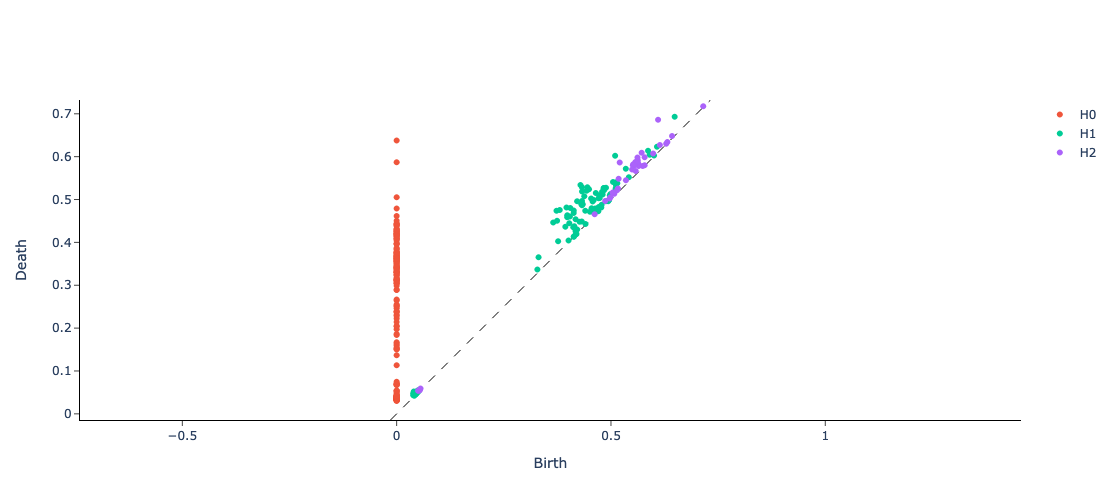

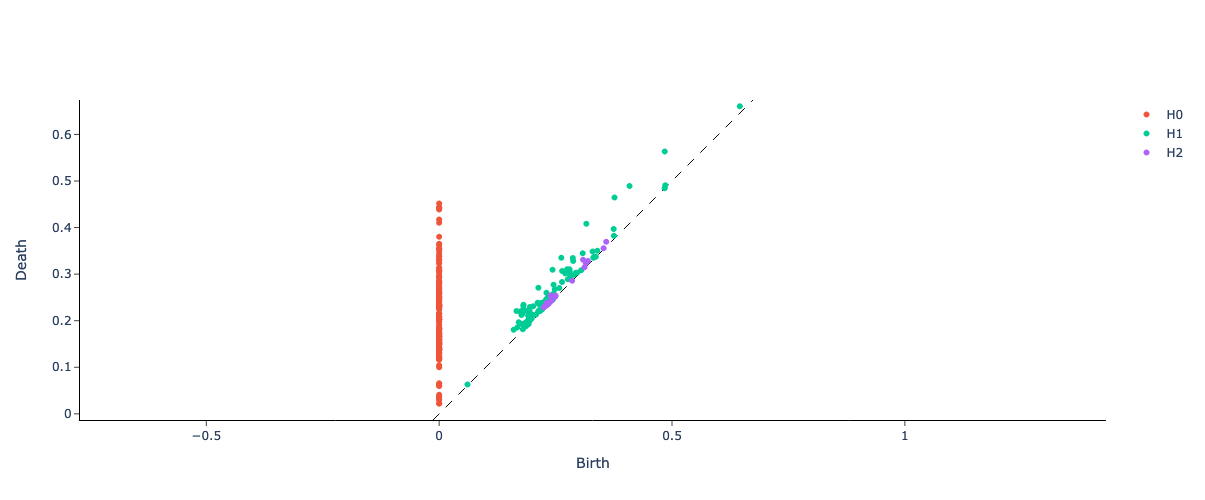

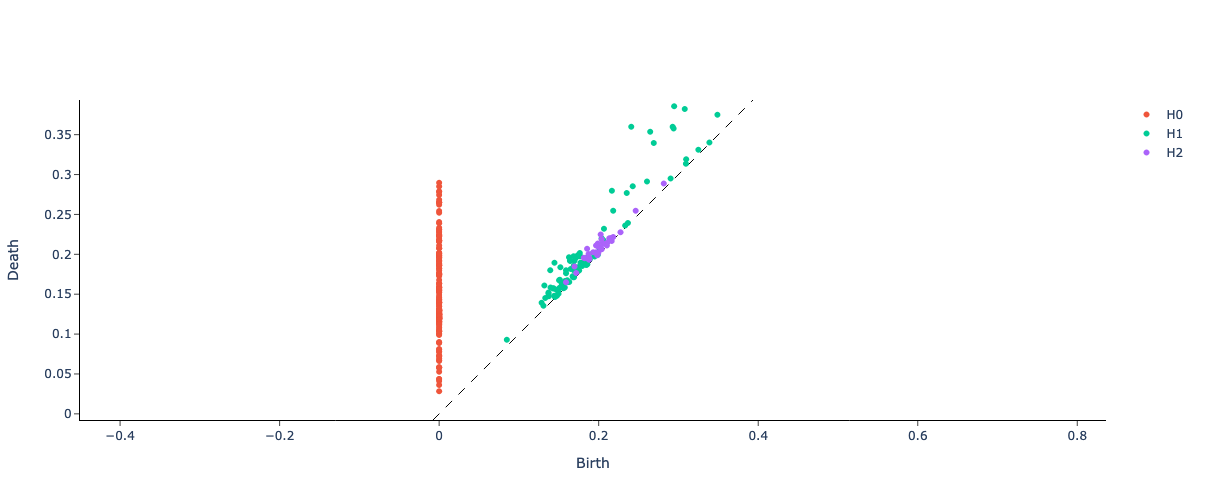

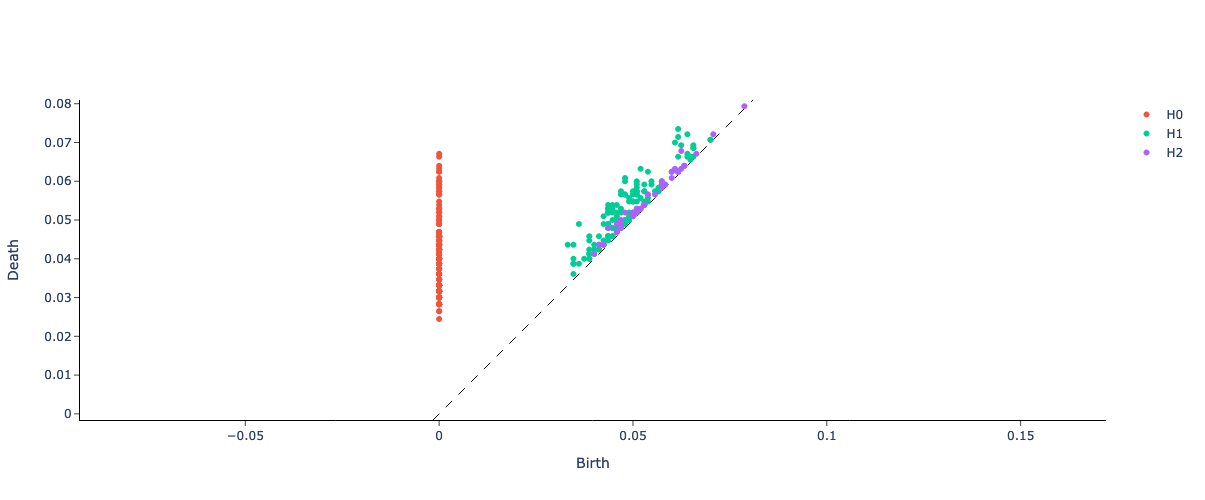

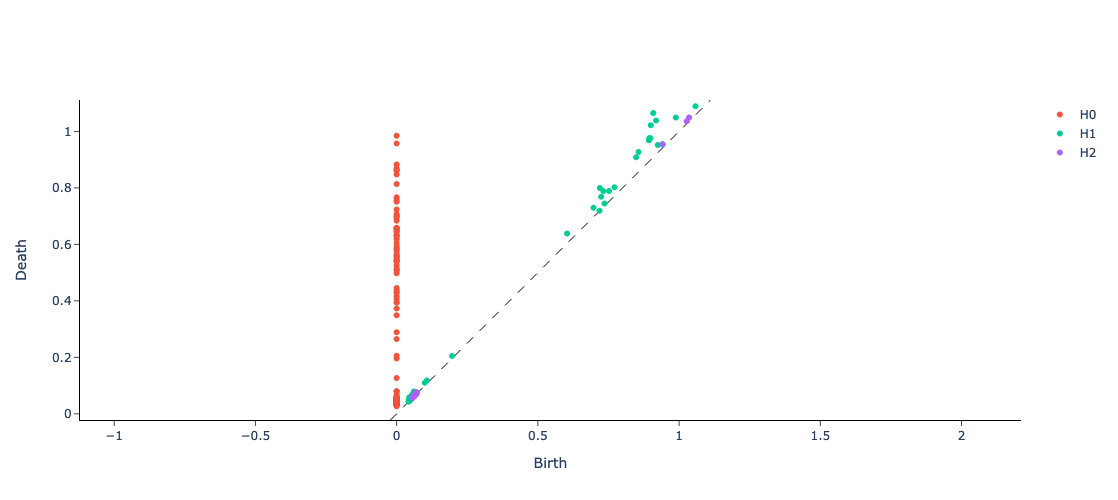

In [52]:
# Finding the most representative diagrams for all labels

representative_diagrams = {} # barycenters for all labels

for label in label_list:
    representative_diagrams["Label_"+str(label)] = find_barycenter(extended_persistence_diagrams, embeddings, label)

In [53]:
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Most_Representative_Diagrams_(Extended_Diagrams).npy', \
            np.array(representative_diagrams, dtype=object), allow_pickle=True)